# Pareto Efficiency Analysis for Topic Modeling

This notebook performs Pareto efficiency analysis on topic modeling results to identify optimal model configurations balancing coherence and topic diversity.

## Overview
- **Input**: Model evaluation results from OCTIS optimization
- **Analysis**: Pareto efficiency identification with two weighting strategies
- **Output**: Top models, visualizations, and hyperparameter analysis

## 1. Setup and Imports

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import pearsonr, spearmanr
import math

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Define paths - calculate project root from current working directory
# Notebook is in notebooks/05_selection/, project root is 2 levels up
current_dir = Path.cwd()
if 'notebooks' in str(current_dir):
    # Running from notebook directory
    project_root = current_dir.parent.parent if '05_selection' in str(current_dir) else current_dir.parent
else:
    # Running from project root or elsewhere - try to find project root
    project_root = current_dir
    # Look for results directory to confirm we're in the right place
    if not (project_root / "results").exists():
        # Try going up one level
        project_root = current_dir.parent
        if not (project_root / "results").exists():
            # Last resort: assume we're in project root
            project_root = current_dir

input_csv = project_root / "results/experiments/bill_novels_octis_model_results_all_models.csv"
output_base = project_root / "results/pareto"

# Create output directories
(output_base / "figures").mkdir(parents=True, exist_ok=True)
(output_base / "tables").mkdir(parents=True, exist_ok=True)
(output_base / "top_models").mkdir(parents=True, exist_ok=True)

print(f"Current directory: {current_dir}")
print(f"Project root: {project_root}")
print(f"Input file: {input_csv}")
print(f"Input file exists: {input_csv.exists()}")
print(f"Output directory: {output_base}")

Current directory: /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code/notebooks/05_selection
Project root: /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code
Input file: /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code/results/experiments/bill_novels_octis_model_results_all_models.csv
Input file exists: True
Output directory: /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code/results/pareto


## 2. Data Loading

In [7]:
# Load the model evaluation results
df = pd.read_csv(input_csv)

print(f"Loaded {len(df)} model evaluation results")
print(f"\nColumns: {list(df.columns)}")
print(f"\nShape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Loaded 572 model evaluation results

Columns: ['Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity', 'bertopic__min_topic_size', 'bertopic__top_n_words', 'hdbscan__min_cluster_size', 'hdbscan__min_samples', 'umap__min_dist', 'umap__n_components', 'umap__n_neighbors', 'vectorizer__min_df']

Shape: (572, 12)

First few rows:


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df
0,paraphrase-mpnet-base-v2,0,0.463245,0.820000,127,31,494,28,0.058341,10,11,0.007313
1,paraphrase-mpnet-base-v2,1,0.294120,0.975000,57,37,132,57,0.053015,4,39,0.004806
2,paraphrase-mpnet-base-v2,2,0.428778,0.673810,143,35,432,43,0.021341,7,8,0.007915
3,paraphrase-mpnet-base-v2,3,0.289018,0.842857,234,25,100,62,0.061487,2,20,0.003023
4,paraphrase-mpnet-base-v2,4,0.345422,0.900000,182,18,493,86,0.011554,2,41,0.001891


## 3. Data Cleaning

Remove outliers using the same approach as the original analysis:
1. Remove runs where Topic_Diversity or Coherence equals 1.0 (failed runs)
2. Remove outliers beyond 2 standard deviations from the mean (both upper and lower bounds)

After removing failed runs (== 1.0): 332 models

Coherence bounds: [0.1831, 0.5990]
Topic Diversity bounds: [0.3966, 0.9976]


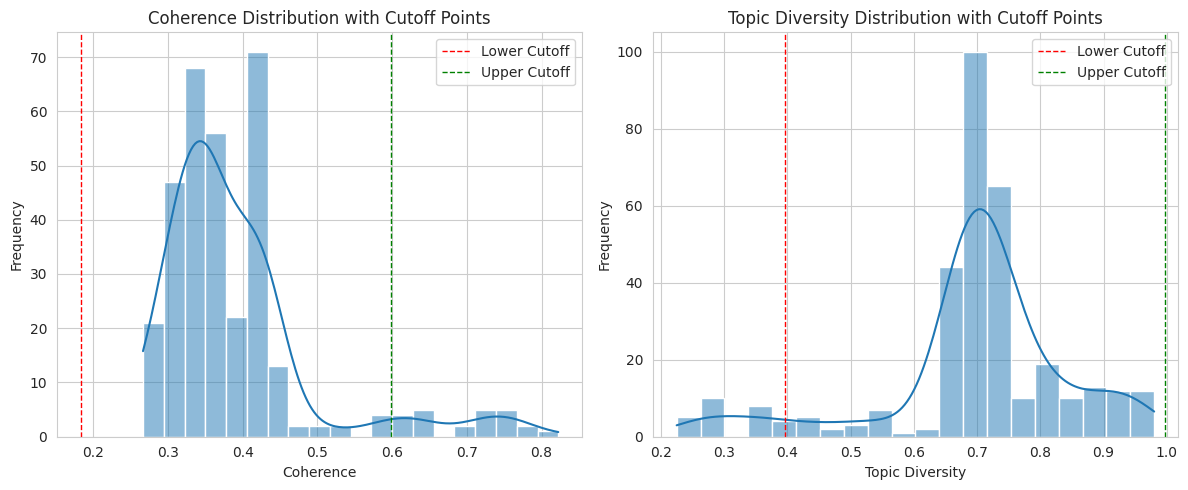


After removing outliers (2 std dev): 303 models

Descriptive statistics after cleaning:


,Coherence,Topic_Diversity
count,303.000000,303.000000
mean,0.364145,0.732894
std,0.051487,0.098192
min,0.266410,0.400000
25%,0.325831,0.685010
50%,0.352452,0.711111
75%,0.415194,0.753743
max,0.577551,0.980000


In [29]:
# Remove runs where Topic Diversity or Coherence is exactly 1 (failed runs)
df_clean = df[(df['Topic_Diversity'] < 1.0) & (df['Coherence'] < 1.0)].copy()
print(f"After removing failed runs (== 1.0): {len(df_clean)} models")

# Compute mean and standard deviation for outlier detection
coherence_mean = df_clean['Coherence'].mean()
coherence_std = df_clean['Coherence'].std()
topic_diversity_mean = df_clean['Topic_Diversity'].mean()
topic_diversity_std = df_clean['Topic_Diversity'].std()

# Define bounds (2 standard deviations)
coherence_lower = coherence_mean - 2 * coherence_std
coherence_upper = coherence_mean + 2 * coherence_std
topic_diversity_lower = topic_diversity_mean - 2 * topic_diversity_std
topic_diversity_upper = topic_diversity_mean + 2 * topic_diversity_std

print(f"\nCoherence bounds: [{coherence_lower:.4f}, {coherence_upper:.4f}]")
print(f"Topic Diversity bounds: [{topic_diversity_lower:.4f}, {topic_diversity_upper:.4f}]")

# Plot distributions with cutoff points (using seaborn histplot with KDE for better visualization)
plt.figure(figsize=(12, 5))

# Coherence distribution
plt.subplot(1, 2, 1)
sns.histplot(df_clean['Coherence'], bins=20, kde=True)
plt.axvline(coherence_lower, color='red', linestyle='dashed', linewidth=1, label='Lower Cutoff')
plt.axvline(coherence_upper, color='green', linestyle='dashed', linewidth=1, label='Upper Cutoff')
plt.title('Coherence Distribution with Cutoff Points')
plt.xlabel('Coherence')
plt.ylabel('Frequency')
plt.legend()

# Topic Diversity distribution
plt.subplot(1, 2, 2)
sns.histplot(df_clean['Topic_Diversity'], bins=20, kde=True)
plt.axvline(topic_diversity_lower, color='red', linestyle='dashed', linewidth=1, label='Lower Cutoff')
plt.axvline(topic_diversity_upper, color='green', linestyle='dashed', linewidth=1, label='Upper Cutoff')
plt.title('Topic Diversity Distribution with Cutoff Points')
plt.xlabel('Topic Diversity')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.savefig(output_base / "figures/distribution_with_cutoffs.png", dpi=150, bbox_inches='tight')
plt.show()

# Remove outliers sequentially (matching legacy approach)
# First remove outliers from Coherence
df_clean = df_clean[(df_clean['Coherence'] >= coherence_lower) & (df_clean['Coherence'] <= coherence_upper)]

# Then remove outliers from Topic Diversity
df_clean = df_clean[(df_clean['Topic_Diversity'] >= topic_diversity_lower) & (df_clean['Topic_Diversity'] <= topic_diversity_upper)]

# Reset the index after removing outliers
df_clean = df_clean.reset_index(drop=True)

print(f"\nAfter removing outliers (2 std dev): {len(df_clean)} models")
print("\nDescriptive statistics after cleaning:")
df_clean[['Coherence', 'Topic_Diversity']].describe()

## 4. Metric Normalization

Apply Z-score normalization to make Coherence and Topic Diversity comparable for the combined score calculation.

In [32]:
# Apply Z-score normalization
scaler = StandardScaler()
df_clean[['Coherence_norm', 'Topic_Diversity_norm']] = scaler.fit_transform(
    df_clean[['Coherence', 'Topic_Diversity']]
)

print("Normalized metrics (sample):")
df_clean[['Coherence', 'Coherence_norm', 'Topic_Diversity', 'Topic_Diversity_norm']].head()

Normalized metrics (sample):


,Coherence,Coherence_norm,Topic_Diversity,Topic_Diversity_norm
0,0.463245,1.927944,0.820000,0.888560
1,0.294120,-1.362296,0.975000,2.469707
2,0.428778,1.257411,0.673810,-0.602721
3,0.289018,-1.461556,0.842857,1.121725
4,0.345422,-0.364249,0.900000,1.704636


## 5. Combined Score Calculation (Equal Weights)

Calculate combined score with equal weights for coherence and topic diversity (0.5 each).

In [33]:
# Define weights for equal weighting strategy
weight_coherence = 0.5
weight_topic_diversity = 0.5

# Calculate combined score
df_clean['Combined_Score'] = (
    weight_coherence * df_clean['Coherence_norm'] + 
    weight_topic_diversity * df_clean['Topic_Diversity_norm']
)

# Rank by combined score
df_sorted = df_clean.sort_values(by='Combined_Score', ascending=False).reset_index(drop=True)

print(f"Top 10 Models Based on Combined Score (Equal Weights):")
top_10_equal = df_sorted.head(10)
display(top_10_equal[['Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity', 
                       'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']])

Top 10 Models Based on Combined Score (Equal Weights):


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,Coherence_norm,Topic_Diversity_norm,Combined_Score
0,paraphrase-MiniLM-L6-v2,19,0.425237,0.940000,1.188516,2.112674,1.650595
1,paraphrase-mpnet-base-v2,0,0.463245,0.820000,1.927944,0.888560,1.408252
2,paraphrase-mpnet-base-v2,14,0.469187,0.800000,2.043541,0.684541,1.364041
3,multi-qa-mpnet-base-cos-v1,26,0.402483,0.900000,0.745838,1.704636,1.225237
4,paraphrase-mpnet-base-v2,13,0.452912,0.800000,1.726922,0.684541,1.205732
5,paraphrase-distilroberta-base-v1,82,0.384683,0.900000,0.399563,1.704636,1.052100
6,multi-qa-mpnet-base-cos-v1,11,0.419208,0.828571,1.071231,0.975997,1.023614
7,paraphrase-MiniLM-L6-v2,28,0.354040,0.950000,-0.196586,2.214684,1.009049
8,multi-qa-mpnet-base-cos-v1,23,0.430575,0.797059,1.292362,0.654539,0.973450
9,all-MiniLM-L12-v2,29,0.375893,0.900000,0.228550,1.704636,0.966593


## 6. Pareto Efficiency Analysis (Equal Weights)

Identify Pareto-efficient models - models where no other model is better in both metrics simultaneously.

In [34]:
def identify_pareto(df, metrics):
    """
    Identify Pareto-efficient points for given metrics.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the data points
    metrics (list): List of column names to use for Pareto analysis
    
    Returns:
    np.array: Boolean array indicating whether each row is Pareto-efficient
    """
    pareto_efficient = np.ones(df.shape[0], dtype=bool)
    # Use enumerate to get positional index, not DataFrame index
    for pos_idx, (df_idx, row) in enumerate(df.iterrows()):
        # If there are any other points that are strictly better, mark as not Pareto-efficient
        # Compare current row with all rows (including itself)
        other_rows_better = (
            np.all(df[metrics].values >= row[metrics].values, axis=1) & 
            np.any(df[metrics].values > row[metrics].values, axis=1)
        )
        pareto_efficient[pos_idx] = not np.any(other_rows_better)
    return pareto_efficient

# Identify Pareto-efficient models (overall)
df_clean['Pareto_Efficient_All'] = identify_pareto(
    df_clean, ['Coherence_norm', 'Topic_Diversity_norm']
)

# Identify Pareto-efficient models per embedding model
df_clean['Pareto_Efficient_PerModel'] = False
for model_name, group in df_clean.groupby('Embeddings_Model'):
    pareto_flags = identify_pareto(group, ['Coherence_norm', 'Topic_Diversity_norm'])
    df_clean.loc[group.index, 'Pareto_Efficient_PerModel'] = pareto_flags

pareto_all_count = df_clean['Pareto_Efficient_All'].sum()
pareto_per_model_count = df_clean['Pareto_Efficient_PerModel'].sum()

print(f"Pareto-efficient models (overall): {pareto_all_count}")
print(f"Pareto-efficient models (per model): {pareto_per_model_count}")


Pareto-efficient models (overall): 10
Pareto-efficient models (per model): 31


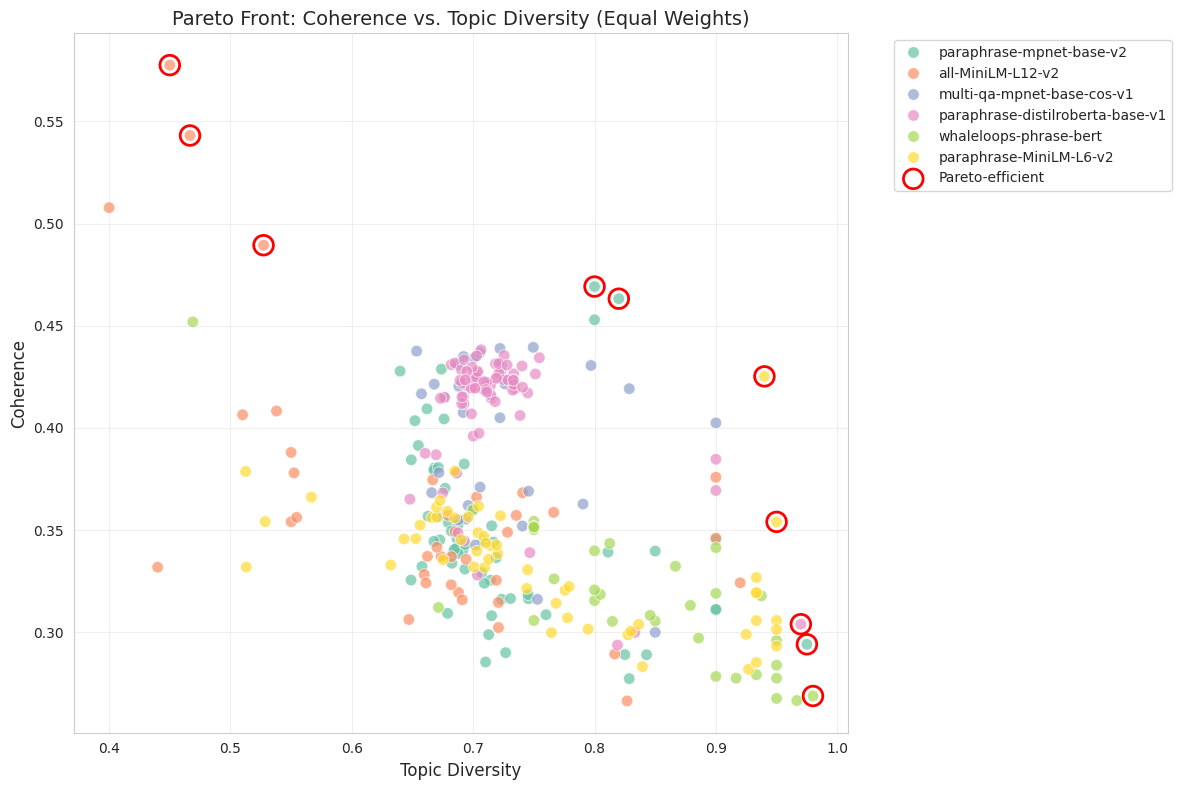

In [35]:
# Create comprehensive scatter plot showing Pareto front
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all models
sns.scatterplot(
    data=df_clean, 
    x='Topic_Diversity', 
    y='Coherence', 
    hue='Embeddings_Model',
    palette='Set2', 
    s=70, 
    alpha=0.7,
    ax=ax
)

# Highlight Pareto-efficient models
pareto_models = df_clean[df_clean['Pareto_Efficient_All']]
ax.scatter(
    pareto_models['Topic_Diversity'], 
    pareto_models['Coherence'],
    facecolors='none', 
    edgecolors='red', 
    s=200, 
    linewidths=2, 
    label='Pareto-efficient',
    zorder=10
)

ax.set_title('Pareto Front: Coherence vs. Topic Diversity (Equal Weights)', fontsize=14)
ax.set_xlabel('Topic Diversity', fontsize=12)
ax.set_ylabel('Coherence', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_base / "figures/pareto_front_equal_weights.png", dpi=150, bbox_inches='tight')
plt.show()


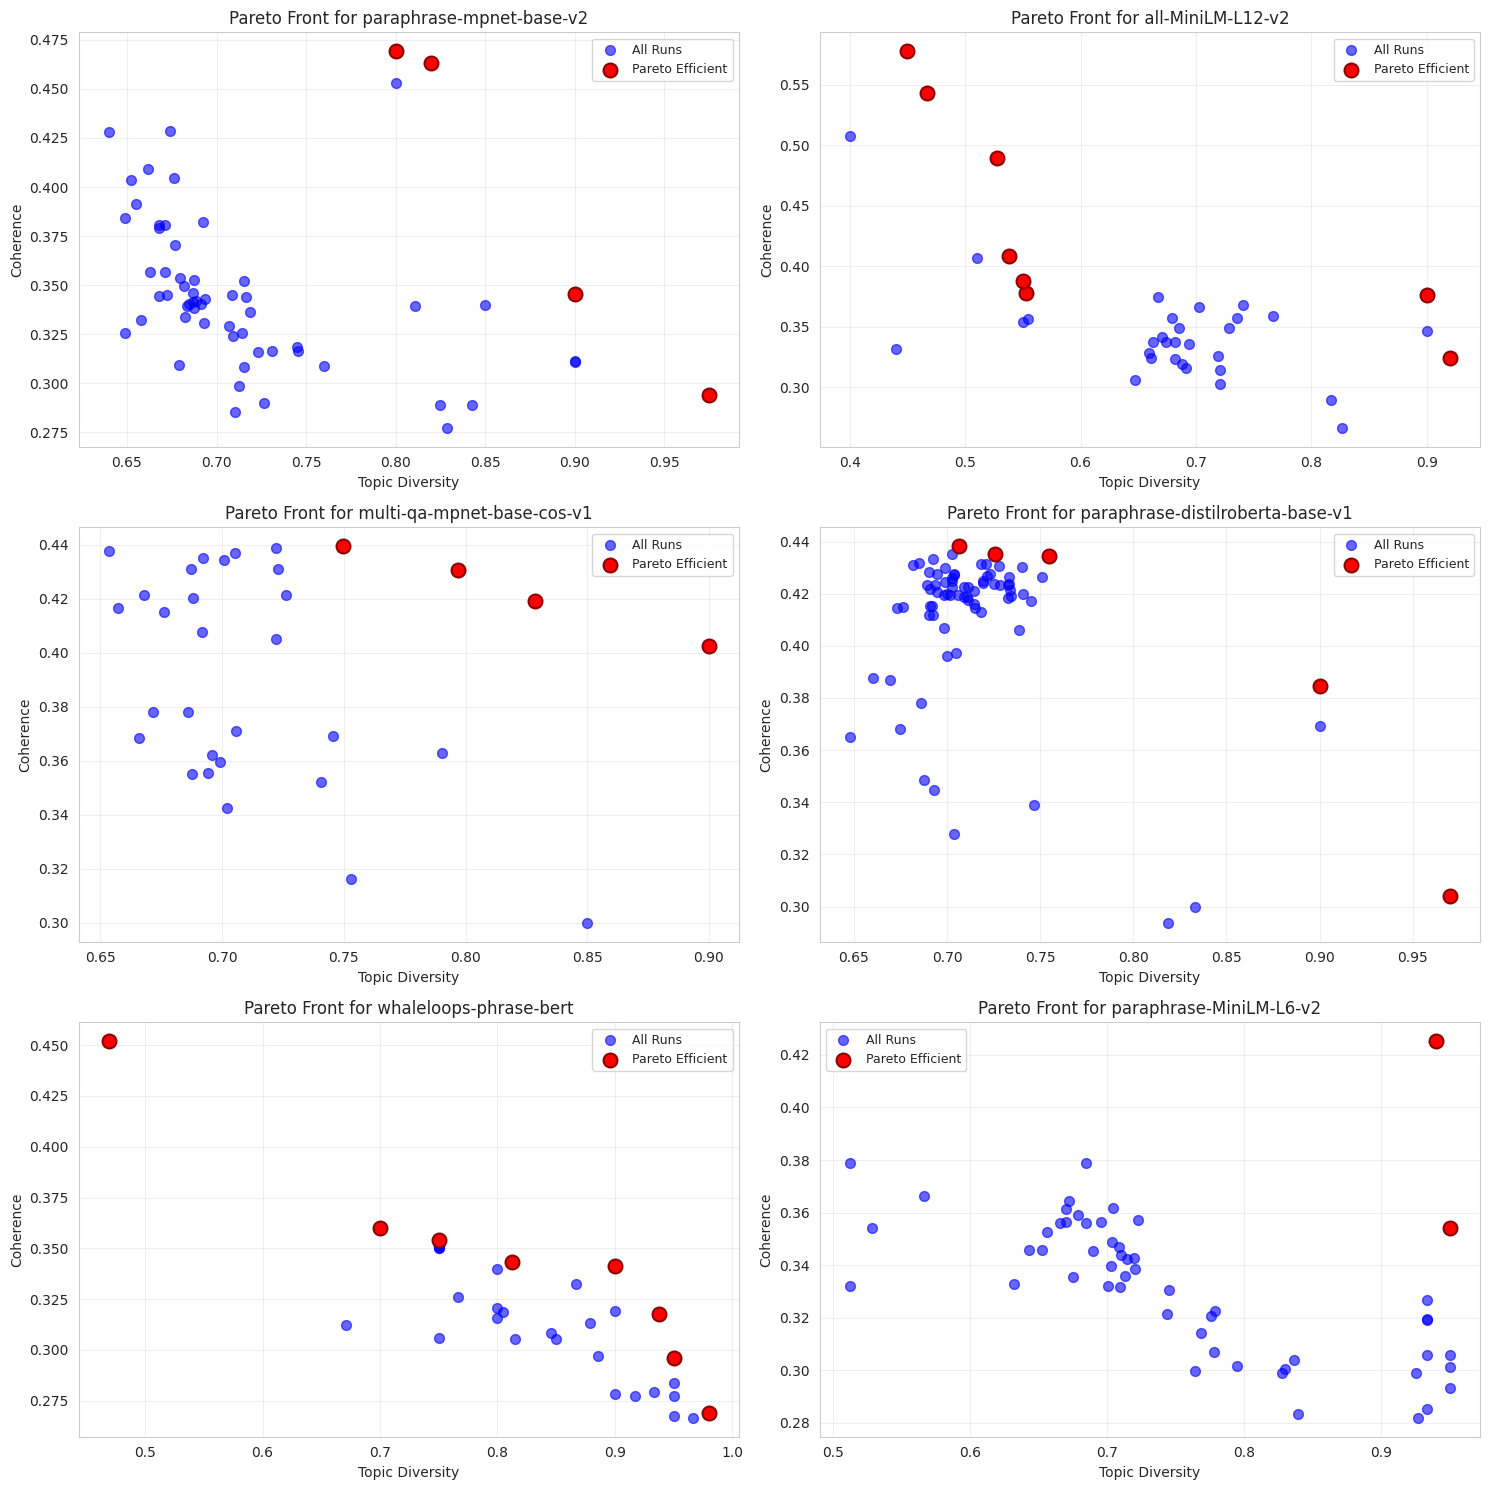

In [36]:
# Create per-model Pareto front plots
unique_models = df_clean['Embeddings_Model'].unique()
num_models = len(unique_models)
cols = 2
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if num_models > 1 else [axes]

for i, model_name in enumerate(unique_models):
    subset = df_clean[df_clean['Embeddings_Model'] == model_name]
    
    # Scatter plot of all runs
    axes[i].scatter(
        subset['Topic_Diversity'], 
        subset['Coherence'], 
        label='All Runs', 
        color='blue', 
        alpha=0.6,
        s=50
    )
    
    # Highlight Pareto-efficient runs
    pareto_subset = subset[subset['Pareto_Efficient_PerModel']]
    if len(pareto_subset) > 0:
        axes[i].scatter(
            pareto_subset['Topic_Diversity'], 
            pareto_subset['Coherence'], 
            label='Pareto Efficient', 
            color='red', 
            s=100,
            edgecolors='darkred',
            linewidths=1.5
        )
    
    axes[i].set_title(f'Pareto Front for {model_name}', fontsize=12)
    axes[i].set_xlabel('Topic Diversity', fontsize=10)
    axes[i].set_ylabel('Coherence', fontsize=10)
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for i in range(num_models, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(output_base / "figures/pareto_fronts_per_model.png", dpi=150, bbox_inches='tight')
plt.show()


In [37]:
# Summary statistics by embedding model for Pareto-efficient models
pareto_efficient_models = df_clean[df_clean['Pareto_Efficient_All']]
pareto_grouped = pareto_efficient_models.groupby('Embeddings_Model').agg({
    'Coherence_norm': ['mean', 'std', 'count'],
    'Topic_Diversity_norm': ['mean', 'std', 'count'],
    'Combined_Score': ['mean', 'std', 'count']
}).reset_index()

pareto_grouped.columns = [
    'Embeddings_Model',
    'Coherence_mean', 'Coherence_std', 'Coherence_count',
    'Diversity_mean', 'Diversity_std', 'Diversity_count',
    'Combined_mean', 'Combined_std', 'Combined_count'
]

print("Performance of Embedding Models in Pareto-Efficient Models:")
display(pareto_grouped)

# Select top 10 Pareto-efficient models
top_10_equal_weights = pareto_efficient_models.nlargest(10, 'Combined_Score')
print(f"\nTop 10 Pareto-efficient Models (Equal Weights):")
display(top_10_equal_weights[['Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity',
                              'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']])

# Save top 10 models
top_10_equal_weights.to_csv(output_base / "top_models/top_10_equal_weights.csv", index=False)
print(f"\nSaved top 10 models to: {output_base / 'top_models/top_10_equal_weights.csv'}")


Performance of Embedding Models in Pareto-Efficient Models:


,Embeddings_Model,Coherence_mean,Coherence_std,Coherence_count,Diversity_mean,Diversity_std,Diversity_count,Combined_mean,Combined_std,Combined_count
0,all-MiniLM-L12-v2,3.356809,0.864058,3,-2.566367,0.414824,3,0.395221,0.231820,3
1,paraphrase-MiniLM-L6-v2,0.495965,0.979415,2,2.163679,0.072132,2,1.329822,0.453642,2
2,paraphrase-distilroberta-base-v1,-1.170840,NaN,1,2.418703,NaN,1,0.623931,NaN,1
3,paraphrase-mpnet-base-v2,0.869729,1.933855,3,1.347603,0.977110,3,1.108666,0.481118,3
4,whaleloops-phrase-bert,-1.854420,NaN,1,2.520712,NaN,1,0.333146,NaN,1



Top 10 Pareto-efficient Models (Equal Weights):


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,Coherence_norm,Topic_Diversity_norm,Combined_Score
258,paraphrase-MiniLM-L6-v2,19,0.425237,0.940000,1.188516,2.112674,1.650595
0,paraphrase-mpnet-base-v2,0,0.463245,0.820000,1.927944,0.888560,1.408252
6,paraphrase-mpnet-base-v2,14,0.469187,0.800000,2.043541,0.684541,1.364041
264,paraphrase-MiniLM-L6-v2,28,0.354040,0.950000,-0.196586,2.214684,1.009049
77,all-MiniLM-L12-v2,66,0.577551,0.450000,4.151702,-2.885791,0.632956
133,paraphrase-distilroberta-base-v1,6,0.303962,0.970000,-1.170840,2.418703,0.623931
1,paraphrase-mpnet-base-v2,1,0.294120,0.975000,-1.362296,2.469707,0.553706
81,all-MiniLM-L12-v2,75,0.543105,0.466667,3.481574,-2.715775,0.382899
209,whaleloops-phrase-bert,5,0.268824,0.980000,-1.854420,2.520712,0.333146
78,all-MiniLM-L12-v2,67,0.489419,0.527273,2.437151,-2.097535,0.169808



Saved top 10 models to: /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code/results/pareto/top_models/top_10_equal_weights.csv


## 7. Combined Score Calculation (Coherence Priority)

Recalculate combined score with higher weight on coherence (0.7) and lower weight on topic diversity (0.3).

In [38]:
# Define weights for coherence priority strategy
weight_coherence = 0.7
weight_topic_diversity = 0.3

# Recalculate combined score
df_clean['Combined_Score'] = (
    weight_coherence * df_clean['Coherence_norm'] + 
    weight_topic_diversity * df_clean['Topic_Diversity_norm']
)

# Re-identify Pareto-efficient models
df_clean['Pareto_Efficient'] = identify_pareto(
    df_clean, ['Coherence_norm', 'Topic_Diversity_norm']
)

# Rank by combined score
df_sorted_priority = df_clean.sort_values(by='Combined_Score', ascending=False).reset_index(drop=True)

print(f"Top 10 Models Based on Combined Score (Coherence Priority):")
display(df_sorted_priority.head(10)[['Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity',
                                      'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']])


Top 10 Models Based on Combined Score (Coherence Priority):


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,Coherence_norm,Topic_Diversity_norm,Combined_Score
0,all-MiniLM-L12-v2,66,0.577551,0.450000,4.151702,-2.885791,2.040454
1,paraphrase-mpnet-base-v2,14,0.469187,0.800000,2.043541,0.684541,1.635841
2,all-MiniLM-L12-v2,75,0.543105,0.466667,3.481574,-2.715775,1.622369
3,paraphrase-mpnet-base-v2,0,0.463245,0.820000,1.927944,0.888560,1.616129
4,paraphrase-MiniLM-L6-v2,19,0.425237,0.940000,1.188516,2.112674,1.465763
5,paraphrase-mpnet-base-v2,13,0.452912,0.800000,1.726922,0.684541,1.414208
6,multi-qa-mpnet-base-cos-v1,23,0.430575,0.797059,1.292362,0.654539,1.101015
7,all-MiniLM-L12-v2,67,0.489419,0.527273,2.437151,-2.097535,1.076745
8,multi-qa-mpnet-base-cos-v1,28,0.439447,0.749474,1.464957,0.169125,1.076207
9,multi-qa-mpnet-base-cos-v1,11,0.419208,0.828571,1.071231,0.975997,1.042661


## 8. Pareto Efficiency Analysis (Coherence Priority)

Number of Pareto-efficient Models (Coherence Priority): 10


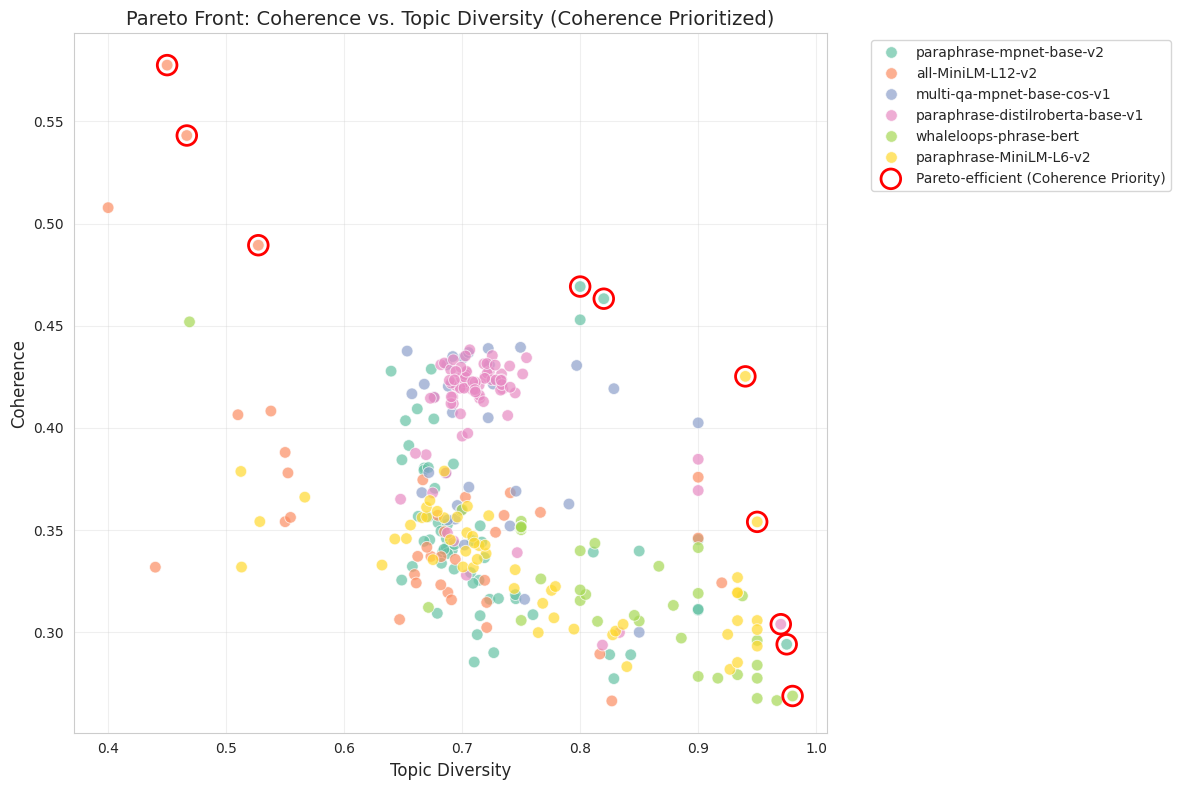


Top 10 Pareto-efficient Models (Coherence Priority):


,Embeddings_Model,Iteration,Coherence,Topic_Diversity,Coherence_norm,Topic_Diversity_norm,Combined_Score
77,all-MiniLM-L12-v2,66,0.577551,0.450000,4.151702,-2.885791,2.040454
6,paraphrase-mpnet-base-v2,14,0.469187,0.800000,2.043541,0.684541,1.635841
81,all-MiniLM-L12-v2,75,0.543105,0.466667,3.481574,-2.715775,1.622369
0,paraphrase-mpnet-base-v2,0,0.463245,0.820000,1.927944,0.888560,1.616129
258,paraphrase-MiniLM-L6-v2,19,0.425237,0.940000,1.188516,2.112674,1.465763
78,all-MiniLM-L12-v2,67,0.489419,0.527273,2.437151,-2.097535,1.076745
264,paraphrase-MiniLM-L6-v2,28,0.354040,0.950000,-0.196586,2.214684,0.526795
133,paraphrase-distilroberta-base-v1,6,0.303962,0.970000,-1.170840,2.418703,-0.093977
1,paraphrase-mpnet-base-v2,1,0.294120,0.975000,-1.362296,2.469707,-0.212695
209,whaleloops-phrase-bert,5,0.268824,0.980000,-1.854420,2.520712,-0.541880



Saved top 10 models to: /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code/results/pareto/top_models/top_10_coherence_priority.csv


In [39]:
# Filter Pareto-efficient models
pareto_efficient_priority = df_clean[df_clean['Pareto_Efficient']]
pareto_count_priority = len(pareto_efficient_priority)

print(f"Number of Pareto-efficient Models (Coherence Priority): {pareto_count_priority}")

# Create scatter plot for coherence-priority Pareto front
fig, ax = plt.subplots(figsize=(12, 8))

sns.scatterplot(
    data=df_clean, 
    x='Topic_Diversity', 
    y='Coherence', 
    hue='Embeddings_Model',
    palette='Set2', 
    s=70, 
    alpha=0.7,
    ax=ax
)

# Highlight Pareto-efficient models
pareto_models_priority = df_clean[df_clean['Pareto_Efficient']]
ax.scatter(
    pareto_models_priority['Topic_Diversity'], 
    pareto_models_priority['Coherence'],
    facecolors='none', 
    edgecolors='red', 
    s=200, 
    linewidths=2, 
    label='Pareto-efficient (Coherence Priority)',
    zorder=10
)

ax.set_title('Pareto Front: Coherence vs. Topic Diversity (Coherence Prioritized)', fontsize=14)
ax.set_xlabel('Topic Diversity', fontsize=12)
ax.set_ylabel('Coherence', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_base / "figures/pareto_front_coherence_priority.png", dpi=150, bbox_inches='tight')
plt.show()

# Select top 10 Pareto-efficient models
top_10_coherence_priority = pareto_efficient_priority.nlargest(10, 'Combined_Score')
print(f"\nTop 10 Pareto-efficient Models (Coherence Priority):")
display(top_10_coherence_priority[['Embeddings_Model', 'Iteration', 'Coherence', 'Topic_Diversity',
                                    'Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']])

# Save top 10 models
top_10_coherence_priority.to_csv(output_base / "top_models/top_10_coherence_priority.csv", index=False)
print(f"\nSaved top 10 models to: {output_base / 'top_models/top_10_coherence_priority.csv'}")


## 9. Hyperparameter Analysis

Analyze relationships between hyperparameters and performance metrics for the top models.


In [41]:
# Load the saved top 10 model sets
df_equal_weights = pd.read_csv(output_base / "top_models/top_10_equal_weights.csv")
df_coherence_priority = pd.read_csv(output_base / "top_models/top_10_coherence_priority.csv")

# Define hyperparameters (all 8 hyperparameters)
hyperparameters = [
    'bertopic__min_topic_size',
    'bertopic__top_n_words',
    'hdbscan__min_cluster_size',
    'hdbscan__min_samples',
    'umap__min_dist',
    'umap__n_components',
    'umap__n_neighbors',
    'vectorizer__min_df'
]

# Verify all hyperparameters are present in the dataframes
missing_eq = [hp for hp in hyperparameters if hp not in df_equal_weights.columns]
missing_pri = [hp for hp in hyperparameters if hp not in df_coherence_priority.columns]

if missing_eq:
    print(f"Warning: Missing hyperparameters in df_equal_weights: {missing_eq}")
if missing_pri:
    print(f"Warning: Missing hyperparameters in df_coherence_priority: {missing_pri}")

if not missing_eq and not missing_pri:
    print(f"✓ All {len(hyperparameters)} hyperparameters are present in both dataframes")

# Performance metrics
performance_metrics = ['Coherence_norm', 'Topic_Diversity_norm', 'Combined_Score']

print("Descriptive Statistics for Hyperparameters (Equal Weights):")
display(df_equal_weights[hyperparameters].describe())

print("\nDescriptive Statistics for Hyperparameters (Coherence Priority):")
display(df_coherence_priority[hyperparameters].describe())


✓ All 8 hyperparameters are present in both dataframes
Descriptive Statistics for Hyperparameters (Equal Weights):


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,88.900000,21.900000,291.000000,55.300000,0.048776,6.200000,27.600000,0.004997
std,33.321498,9.550451,147.127307,26.911584,0.035567,3.155243,15.334783,0.003098
min,37.000000,10.000000,132.000000,14.000000,0.004634,2.000000,7.000000,0.001174
25%,63.250000,12.250000,160.750000,33.250000,0.011041,3.250000,12.000000,0.002018
50%,93.500000,23.000000,267.000000,57.500000,0.055678,6.000000,31.000000,0.005369
75%,108.000000,29.250000,425.000000,72.000000,0.076378,9.000000,41.250000,0.007272
max,142.000000,37.000000,500.000000,92.000000,0.097223,10.000000,45.000000,0.009372



Descriptive Statistics for Hyperparameters (Coherence Priority):


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,88.900000,21.900000,291.000000,55.300000,0.048776,6.200000,27.600000,0.004997
std,33.321498,9.550451,147.127307,26.911584,0.035567,3.155243,15.334783,0.003098
min,37.000000,10.000000,132.000000,14.000000,0.004634,2.000000,7.000000,0.001174
25%,63.250000,12.250000,160.750000,33.250000,0.011041,3.250000,12.000000,0.002018
50%,93.500000,23.000000,267.000000,57.500000,0.055678,6.000000,31.000000,0.005369
75%,108.000000,29.250000,425.000000,72.000000,0.076378,9.000000,41.250000,0.007272
max,142.000000,37.000000,500.000000,92.000000,0.097223,10.000000,45.000000,0.009372


In [42]:
# Calculate correlation matrices
df_equal_filtered = df_equal_weights[hyperparameters + performance_metrics]
df_priority_filtered = df_coherence_priority[hyperparameters + performance_metrics]

correlation_equal = df_equal_filtered.corr()
correlation_priority = df_priority_filtered.corr()

print("Correlation Matrix (Equal Weights):")
display(correlation_equal)

print("\nCorrelation Matrix (Coherence Priority):")
display(correlation_priority)


Correlation Matrix (Equal Weights):


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score
bertopic__min_topic_size,1.000000,-0.238503,0.553028,-0.617760,-0.606621,0.060450,-0.331260,-0.110673,0.585395,-0.591078,-0.098488
bertopic__top_n_words,-0.238503,1.000000,-0.107463,-0.167174,-0.009822,0.037610,-0.117898,-0.084259,0.145747,-0.023787,0.247351
hdbscan__min_cluster_size,0.553028,-0.107463,1.000000,-0.399945,-0.275715,0.202968,-0.796583,0.136964,0.562982,-0.450507,0.165178
hdbscan__min_samples,-0.617760,-0.167174,-0.399945,1.000000,0.440867,-0.198374,0.083788,0.208264,-0.481557,0.407043,-0.093483
umap__min_dist,-0.606621,-0.009822,-0.275715,0.440867,1.000000,0.580086,0.301191,0.709274,-0.527934,0.793502,0.662738
umap__n_components,0.060450,0.037610,0.202968,-0.198374,0.580086,1.000000,0.157992,0.622885,0.144394,0.188496,0.712360
umap__n_neighbors,-0.331260,-0.117898,-0.796583,0.083788,0.301191,0.157992,1.000000,0.097362,-0.572619,0.497294,-0.081898
vectorizer__min_df,-0.110673,-0.084259,0.136964,0.208264,0.709274,0.622885,0.097362,1.000000,-0.302096,0.619849,0.744570
Coherence_norm,0.585395,0.145747,0.562982,-0.481557,-0.527934,0.144394,-0.572619,-0.302096,1.000000,-0.892061,0.091006
Topic_Diversity_norm,-0.591078,-0.023787,-0.450507,0.407043,0.793502,0.188496,0.497294,0.619849,-0.892061,1.000000,0.368857



Correlation Matrix (Coherence Priority):


,bertopic__min_topic_size,bertopic__top_n_words,hdbscan__min_cluster_size,hdbscan__min_samples,umap__min_dist,umap__n_components,umap__n_neighbors,vectorizer__min_df,Coherence_norm,Topic_Diversity_norm,Combined_Score
bertopic__min_topic_size,1.000000,-0.238503,0.553028,-0.617760,-0.606621,0.060450,-0.331260,-0.110673,0.585395,-0.591078,0.501744
bertopic__top_n_words,-0.238503,1.000000,-0.107463,-0.167174,-0.009822,0.037610,-0.117898,-0.084259,0.145747,-0.023787,0.215445
hdbscan__min_cluster_size,0.553028,-0.107463,1.000000,-0.399945,-0.275715,0.202968,-0.796583,0.136964,0.562982,-0.450507,0.569070
hdbscan__min_samples,-0.617760,-0.167174,-0.399945,1.000000,0.440867,-0.198374,0.083788,0.208264,-0.481557,0.407043,-0.470847
umap__min_dist,-0.606621,-0.009822,-0.275715,0.440867,1.000000,0.580086,0.301191,0.709274,-0.527934,0.793502,-0.261397
umap__n_components,0.060450,0.037610,0.202968,-0.198374,0.580086,1.000000,0.157992,0.622885,0.144394,0.188496,0.369044
umap__n_neighbors,-0.331260,-0.117898,-0.796583,0.083788,0.301191,0.157992,1.000000,0.097362,-0.572619,0.497294,-0.550141
vectorizer__min_df,-0.110673,-0.084259,0.136964,0.208264,0.709274,0.622885,0.097362,1.000000,-0.302096,0.619849,-0.027932
Coherence_norm,0.585395,0.145747,0.562982,-0.481557,-0.527934,0.144394,-0.572619,-0.302096,1.000000,-0.892061,0.943424
Topic_Diversity_norm,-0.591078,-0.023787,-0.450507,0.407043,0.793502,0.188496,0.497294,0.619849,-0.892061,1.000000,-0.691743


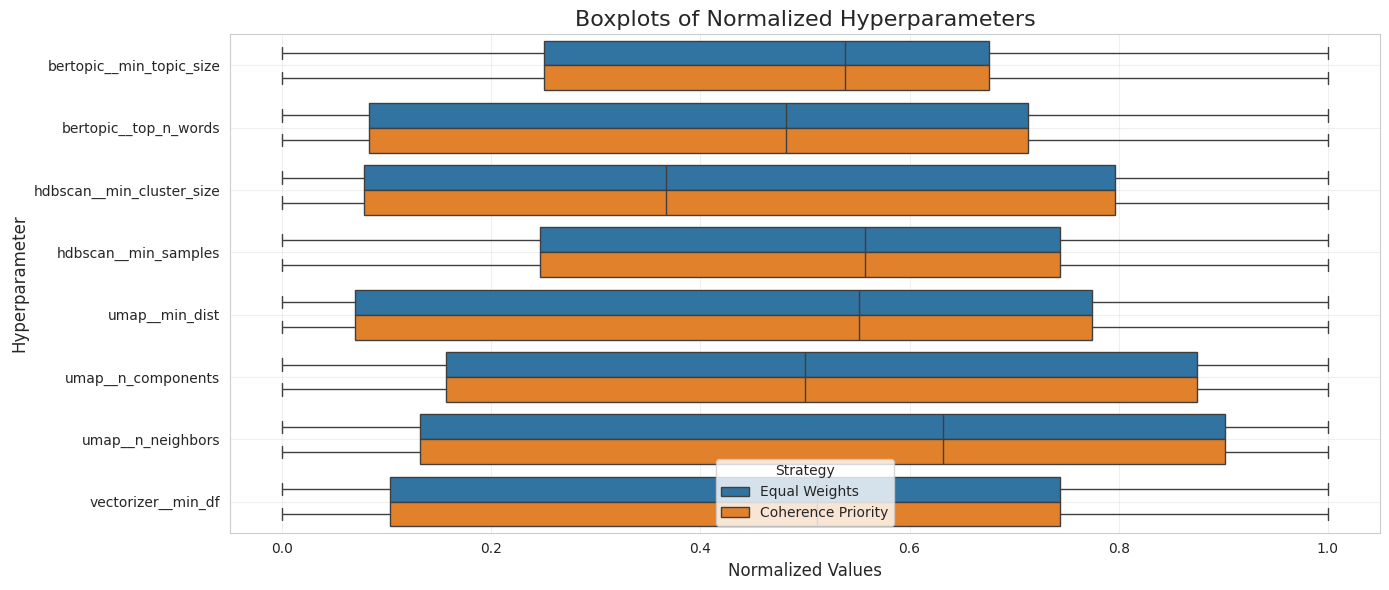

In [43]:
# Create normalized hyperparameter boxplots
scaler_hp = MinMaxScaler()
df_normalized_eq = df_equal_weights.copy()
df_normalized_pri = df_coherence_priority.copy()

df_normalized_eq[hyperparameters] = scaler_hp.fit_transform(df_equal_weights[hyperparameters])
df_normalized_pri[hyperparameters] = scaler_hp.fit_transform(df_coherence_priority[hyperparameters])

# Melt for plotting
df_melted_eq = df_normalized_eq.melt(
    value_vars=hyperparameters,
    var_name='Hyperparameter',
    value_name='Value'
)
df_melted_eq['Strategy'] = 'Equal Weights'

df_melted_pri = df_normalized_pri.melt(
    value_vars=hyperparameters,
    var_name='Hyperparameter',
    value_name='Value'
)
df_melted_pri['Strategy'] = 'Coherence Priority'

df_melted = pd.concat([df_melted_eq, df_melted_pri], ignore_index=True)

# Create boxplots
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(
    data=df_melted,
    x='Value',
    y='Hyperparameter',
    hue='Strategy',
    orient='h',
    ax=ax
)

ax.set_title('Boxplots of Normalized Hyperparameters', fontsize=16)
ax.set_xlabel('Normalized Values', fontsize=12)
ax.set_ylabel('Hyperparameter', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_base / "figures/hyperparameter_boxplots.png", dpi=150, bbox_inches='tight')
plt.show()


In [44]:
# Function to calculate Cohen's d
def cohen_d(group1, group2):
    """Calculate Cohen's d for two groups."""
    diff_mean = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt(((np.std(group1, ddof=1) ** 2) + (np.std(group2, ddof=1) ** 2)) / 2)
    return diff_mean / pooled_std if pooled_std > 0 else 0

# Function to choose correlation test
def choose_test(df, parameter, metric):
    """Choose between Pearson or Spearman based on data distribution."""
    if abs(df[parameter].skew()) < 1:
        corr, p_value = pearsonr(df[parameter], df[metric])
        test_type = "Pearson"
    else:
        corr, p_value = spearmanr(df[parameter], df[metric])
        test_type = "Spearman"
    return corr, p_value, test_type

# Function to calculate Cohen's d between groups
def calculate_cohens_d(df, parameter, metric):
    """Split by median and calculate Cohen's d."""
    median_value = df[parameter].median()
    group1 = df[df[parameter] <= median_value][metric]
    group2 = df[df[parameter] > median_value][metric]
    return cohen_d(group1, group2)

# Analyze correlations and effect sizes
results_equal = {'Hyperparameter': [], 'Metric': [], 'Correlation': [], 'p-value': [], 'Test_Type': [], 'Cohen_d': []}
results_priority = {'Hyperparameter': [], 'Metric': [], 'Correlation': [], 'p-value': [], 'Test_Type': [], 'Cohen_d': []}

for param in hyperparameters:
    for metric in performance_metrics:
        # Equal weights
        corr, p_val, test_type = choose_test(df_equal_weights, param, metric)
        cohens_d_val = calculate_cohens_d(df_equal_weights, param, metric)
        results_equal['Hyperparameter'].append(param)
        results_equal['Metric'].append(metric)
        results_equal['Correlation'].append(corr)
        results_equal['p-value'].append(p_val)
        results_equal['Test_Type'].append(test_type)
        results_equal['Cohen_d'].append(cohens_d_val)
        
        # Coherence priority
        corr, p_val, test_type = choose_test(df_coherence_priority, param, metric)
        cohens_d_val = calculate_cohens_d(df_coherence_priority, param, metric)
        results_priority['Hyperparameter'].append(param)
        results_priority['Metric'].append(metric)
        results_priority['Correlation'].append(corr)
        results_priority['p-value'].append(p_val)
        results_priority['Test_Type'].append(test_type)
        results_priority['Cohen_d'].append(cohens_d_val)

# Convert to DataFrames
correlation_results_equal = pd.DataFrame(results_equal)
correlation_results_priority = pd.DataFrame(results_priority)

print("Correlation and Cohen's d Results (Equal Weights):")
display(correlation_results_equal)

print("\nCorrelation and Cohen's d Results (Coherence Priority):")
display(correlation_results_priority)

# Save results
correlation_results_equal.to_csv(output_base / "tables/correlation_analysis_equal_weights.csv", index=False)
correlation_results_priority.to_csv(output_base / "tables/correlation_analysis_coherence_priority.csv", index=False)

print(f"\nSaved correlation analysis to:")
print(f"  - {output_base / 'tables/correlation_analysis_equal_weights.csv'}")
print(f"  - {output_base / 'tables/correlation_analysis_coherence_priority.csv'}")


Correlation and Cohen's d Results (Equal Weights):


,Hyperparameter,Metric,Correlation,p-value,Test_Type,Cohen_d
0,bertopic__min_topic_size,Coherence_norm,0.585395,0.075410,Pearson,-1.179971
1,bertopic__min_topic_size,Topic_Diversity_norm,-0.591078,0.071934,Pearson,1.623137
2,bertopic__min_topic_size,Combined_Score,-0.098488,0.786635,Pearson,0.664601
3,bertopic__top_n_words,Coherence_norm,0.145747,0.687865,Pearson,-0.566877
4,bertopic__top_n_words,Topic_Diversity_norm,-0.023787,0.947996,Pearson,0.396484
5,bertopic__top_n_words,Combined_Score,0.247351,0.490827,Pearson,-0.261204
6,hdbscan__min_cluster_size,Coherence_norm,0.562982,0.090180,Pearson,-1.064133
7,hdbscan__min_cluster_size,Topic_Diversity_norm,-0.450507,0.191347,Pearson,0.809358
8,hdbscan__min_cluster_size,Combined_Score,0.165178,0.648372,Pearson,-0.258745
9,hdbscan__min_samples,Coherence_norm,-0.481557,0.158764,Pearson,0.432597



Correlation and Cohen's d Results (Coherence Priority):


,Hyperparameter,Metric,Correlation,p-value,Test_Type,Cohen_d
0,bertopic__min_topic_size,Coherence_norm,0.585395,0.075410,Pearson,-1.179971
1,bertopic__min_topic_size,Topic_Diversity_norm,-0.591078,0.071934,Pearson,1.623137
2,bertopic__min_topic_size,Combined_Score,0.501744,0.139510,Pearson,-0.750389
3,bertopic__top_n_words,Coherence_norm,0.145747,0.687865,Pearson,-0.566877
4,bertopic__top_n_words,Topic_Diversity_norm,-0.023787,0.947996,Pearson,0.396484
5,bertopic__top_n_words,Combined_Score,0.215445,0.549987,Pearson,-0.612537
6,hdbscan__min_cluster_size,Coherence_norm,0.562982,0.090180,Pearson,-1.064133
7,hdbscan__min_cluster_size,Topic_Diversity_norm,-0.450507,0.191347,Pearson,0.809358
8,hdbscan__min_cluster_size,Combined_Score,0.569070,0.085999,Pearson,-1.073321
9,hdbscan__min_samples,Coherence_norm,-0.481557,0.158764,Pearson,0.432597



Saved correlation analysis to:
  - /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code/results/pareto/tables/correlation_analysis_equal_weights.csv
  - /home/polina/Documents/goodreads_romance_research_cursor/romantic_novels_project_code/results/pareto/tables/correlation_analysis_coherence_priority.csv
